In [1]:
import rustworkx as rx
import numpy as np
import matplotlib.pyplot as plt
from rustworkx.visualization import mpl_draw as draw_graph
from qiskit_ibm_runtime import QiskitRuntimeService
from scipy.optimize import minimize

from qiskit import QuantumCircuit
from qiskit.providers.fake_provider import GenericBackendV2
from qiskit.quantum_info import SparsePauliOp, Statevector, DensityMatrix, Operator
from qiskit.circuit.library import QAOAAnsatz
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.visualization import plot_histogram
from qiskit.transpiler import Layout

from qiskit_ibm_runtime import (
    Session,
    EstimatorV2 as Estimator,
    SamplerV2 as Sampler,
    EstimatorOptions,
)
from qiskit_ibm_runtime.debug_tools import Neat
from qiskit_aer import AerSimulator

from utils import zne_method, plot_zne, plot_backend_errors_and_counts
from qc_grader.challenges.qgss_2025 import (
    grade_lab2_ex1,
    grade_lab2_ex2,
    grade_lab2_ex3,
    grade_lab2_ex4,
    grade_lab2_ex5,
    grade_lab2_ex6a,
    grade_lab2_ex6b,
)


In [2]:
# Check that the account has been saved properly
from qiskit_ibm_runtime import QiskitRuntimeService


service = QiskitRuntimeService(name="qgss-2025")
service.saved_accounts()

{'qgss-2025': {'channel': 'ibm_quantum_platform',
  'url': 'https://cloud.ibm.com',
  'token': 'Y5wDjNuGer1keOHMzwkj_5UoHJud8RPTvfc_yZxqglHQ',
  'instance': 'crn:v1:bluemix:public:quantum-computing:us-east:a/0cbc0b1bde824777bfe56bd9c72ece9c:4e2e877c-d5e3-49a4-8dbd-902ac7733cef::',
  'verify': True,
  'private_endpoint': False}}

In [3]:
import rustworkx as rx
import numpy as np
import matplotlib.pyplot as plt
from rustworkx.visualization import mpl_draw as draw_graph
from qiskit_ibm_runtime import QiskitRuntimeService
from scipy.optimize import minimize

from qiskit import QuantumCircuit
from qiskit.providers.fake_provider import GenericBackendV2
from qiskit.quantum_info import SparsePauliOp, Statevector, DensityMatrix, Operator
from qiskit.circuit.library import QAOAAnsatz
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.visualization import plot_histogram
from qiskit.transpiler import Layout

from qiskit_ibm_runtime import (
    Session,
    EstimatorV2 as Estimator,
    SamplerV2 as Sampler,
    EstimatorOptions,
)
from qiskit_ibm_runtime.debug_tools import Neat
from qiskit_aer import AerSimulator

from utils import zne_method, plot_zne, plot_backend_errors_and_counts
from qc_grader.challenges.qgss_2025 import (
    grade_lab2_ex1,
    grade_lab2_ex2,
    grade_lab2_ex3,
    grade_lab2_ex4,
    grade_lab2_ex5,
    grade_lab2_ex6a,
    grade_lab2_ex6b,
)

In [4]:
# Execute to make arrays of properties
service = QiskitRuntimeService(name="qgss-2025")
# We define a specific backend
brisbane_backend = service.backend("ibm_brisbane")
# We obtain the system properties, number of qubits and coupling map
properties = brisbane_backend.properties()
num_qubits = brisbane_backend.num_qubits
coupling_map = brisbane_backend.coupling_map

# We define various lists of metrics for all the qubits of the backend
t1, t2, gate_error_x, readout_error, gate_error_ecr = [], [], [], [], []
for i in range(num_qubits):
    t1.append(properties.t1(i))
    t2.append(properties.t2(i))
    gate_error_x.append(properties.gate_error(gate="x", qubits=i))
    readout_error.append(properties.readout_error(i))
for pair in coupling_map:
    gate_error_ecr.append(properties.gate_error(gate="ecr", qubits=pair))

In [5]:
def find_best_metrics(backend: QiskitRuntimeService.backend) -> list[tuple[int or list, float]]:
    """Finds the best-performing qubits and qubit pair based on various hardware metrics."""
    
    properties = backend.properties()
    num_qubits = backend.num_qubits
    coupling_map = backend.coupling_map

    # Create lists of metrics for each qubit
    t1 = [properties.t1(i) for i in range(num_qubits)]
    t2 = [properties.t2(i) for i in range(num_qubits)]
    gate_error_x = [properties.gate_error(gate="x", qubits=i) for i in range(num_qubits)]
    readout_error = [properties.readout_error(i) for i in range(num_qubits)]

    # Create list of (qubit_pair, error) for ECR gate
    gate_error_ecr = [
        (pair, properties.gate_error(gate="ecr", qubits=pair))
        for pair in coupling_map
    ]

    # Find best individual qubits
    index_t1_max = t1.index(max(t1))
    max_t1 = max(t1)

    index_t2_max = t2.index(max(t2))
    max_t2 = max(t2)

    index_min_x_error = gate_error_x.index(min(gate_error_x))
    min_x_error = min(gate_error_x)

    index_min_readout = readout_error.index(min(readout_error))
    min_readout = min(readout_error)

    # Find best qubit pair for ECR gate
    min_ecr_pair, min_ecr_error = min(gate_error_ecr, key=lambda x: x[1])

    # Return the final summary list
    solutions = [
        [int(index_t1_max), max_t1],
        [int(index_t2_max), max_t2],
        [int(index_min_x_error), min_x_error],
        [int(index_min_readout), min_readout],
        [list(min_ecr_pair), min_ecr_error],
    ]
    return solutions

In [6]:
service = QiskitRuntimeService(name="qgss-2025")
backend = service.backend("ibm_brisbane")
print(find_best_metrics(backend))

[[30, 0.00045218744777477955], [29, 0.0003677584746528739], [18, 0.00011848417858395745], [47, 0.00537109375], [[4, 3], 0.0025925971459754282]]


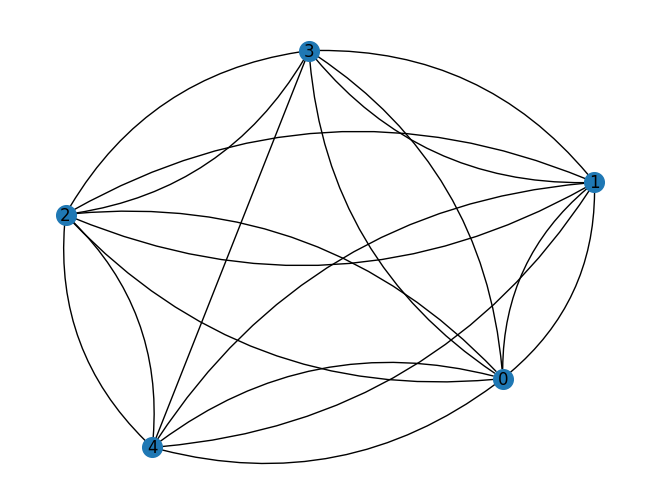

In [7]:


# We define the seed
seed = 43
# We define the number of nodes:
n = 5
# We define the graph
graph = rx.PyGraph()
graph.add_nodes_from(np.arange(0, n, 1))
generic_backend = GenericBackendV2(n, seed=seed)
weights = 1
# We make it explicitly asymmetrical to have a smaller set of solutions
graph.add_edges_from([(edge[0], edge[1], weights) for edge in generic_backend.coupling_map][:-1])
draw_graph(graph, node_size=200, with_labels=True, width=1)

In [8]:
# Execute to make arrays of properties
service = QiskitRuntimeService(name="qgss-2025")
# We define a specific backend
brisbane_backend = service.backend("ibm_brisbane")
# We obtain the system properties, number of qubits and coupling map
properties = brisbane_backend.properties()
num_qubits = brisbane_backend.num_qubits
coupling_map = brisbane_backend.coupling_map

# We define various lists of metrics for all the qubits of the backend
t1, t2, gate_error_x, readout_error, gate_error_ecr = [], [], [], [], []
for i in range(num_qubits):
    t1.append(properties.t1(i))
    t2.append(properties.t2(i))
    gate_error_x.append(properties.gate_error(gate="x", qubits=i))
    readout_error.append(properties.readout_error(i))
for pair in coupling_map:
    gate_error_ecr.append(properties.gate_error(gate="ecr", qubits=pair))


In [9]:
def graph_to_Pauli(graph: rx.PyGraph) -> list[tuple[str, float]]:
    """Convert the graph to Pauli list."""
    pauli_list = []

    # ---- TODO : Task 2 ---
    # Goal: Convert the graph into a list like: [['PauliWord_1', weight_1], ['PauliWord_2', weight_2],...]


    for edge in list(graph.edge_list()):
        paulis = ["I"] * len(graph)
        paulis[edge[0]], paulis[edge[1]] = "Z", "Z"
 
        weight = graph.get_edge_data(edge[0], edge[1])
 
        pauli_list.append(("".join(paulis)[::-1], weight))
 
    return pauli_list
 
 
#max_cut_paulis = build_max_cut_paulis(graph_100)
 





max_cut_paulis = graph_to_Pauli(graph)
cost_hamiltonian = SparsePauliOp.from_list(max_cut_paulis)
print("Cost Function Hamiltonian:", cost_hamiltonian)

Cost Function Hamiltonian: SparsePauliOp(['IIIZZ', 'IIIZZ', 'IIZIZ', 'IIZIZ', 'IZIIZ', 'IZIIZ', 'ZIIIZ', 'ZIIIZ', 'IIZZI', 'IIZZI', 'IZIZI', 'IZIZI', 'ZIIZI', 'ZIIZI', 'IZZII', 'IZZII', 'ZIZII', 'ZIZII', 'ZZIII'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
 1.+0.j])


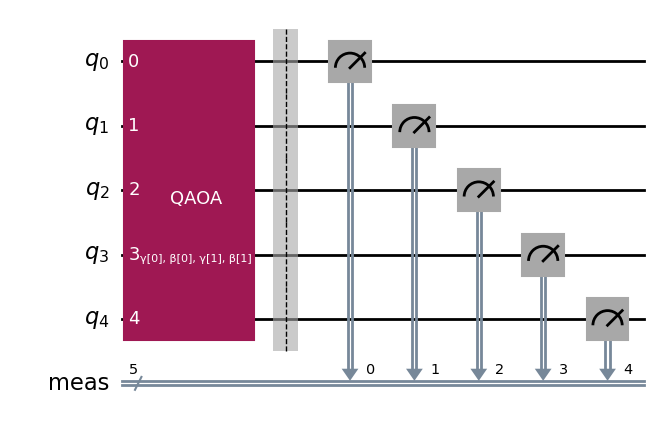

In [10]:
layers = 2
qaoa_circuit = QAOAAnsatz(cost_operator=cost_hamiltonian, reps=layers)
qaoa_circuit.measure_all()
qaoa_circuit.draw("mpl")

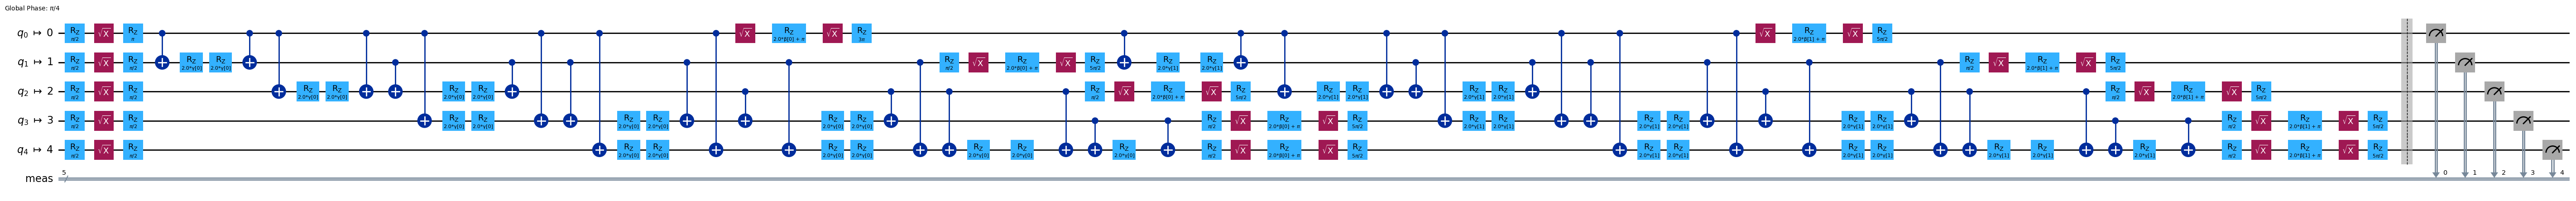

In [11]:
# Create pass manager for transpilation

pm = generate_preset_pass_manager(
    optimization_level=3, backend=generic_backend, seed_transpiler=seed
)

qaoa_circuit_transpiled = pm.run(qaoa_circuit)
qaoa_circuit_transpiled.draw("mpl", fold=False, idle_wires=False)

In [12]:
import numpy as np                                                                                 
init_params = np.zeros(2 * layers)

In [13]:
objective_func_vals = []


def cost_func_estimator(
    params: list, ansatz: QuantumCircuit, isa_hamiltonian: SparsePauliOp, estimator: Estimator
) -> float:
    """Compute the cost function value using a parameterized ansatz and an estimator for a given Hamiltonian."""
    if isa_hamiltonian.num_qubits != ansatz.num_qubits:
        isa_hamiltonian = isa_hamiltonian.apply_layout(ansatz.layout)
    pub = (ansatz, isa_hamiltonian, params)
    job = estimator.run([pub])
    results = job.result()[0]
    cost = results.data.evs
    objective_func_vals.append(cost)
    return cost


def train_qaoa(
    params: list,
    circuit: QuantumCircuit,
    hamiltonian: SparsePauliOp,
    backend: QiskitRuntimeService.backend,
) -> tuple:
    """Optimize QAOA parameters using COBYLA and an estimator on a given backend."""
    with Session(backend=backend) as session:
        options = {"simulator": {"seed_simulator": seed}}
        estimator = Estimator(mode=session, options=options)
        estimator.options.default_shots = 100000

        result = minimize(
            cost_func_estimator,
            params,
            args=(circuit, hamiltonian, estimator),
            method="COBYLA",
            options={"maxiter": 200, "rhobeg": 1, "catol": 1e-3, "tol": 0.0001},
        )
    print(result)
    return result, objective_func_vals


result_qaoa, objective_func_vals = train_qaoa(
    init_params, qaoa_circuit_transpiled, cost_hamiltonian, generic_backend)

 message: Return from COBYLA because the trust region radius reaches its lower bound.
 success: True
  status: 0
     fun: -3.2863771362286376
       x: [ 9.958e-01  1.181e+00  3.710e-02  9.495e-01]
    nfev: 47
   maxcv: 0.0


Text(0, 0.5, 'Cost')

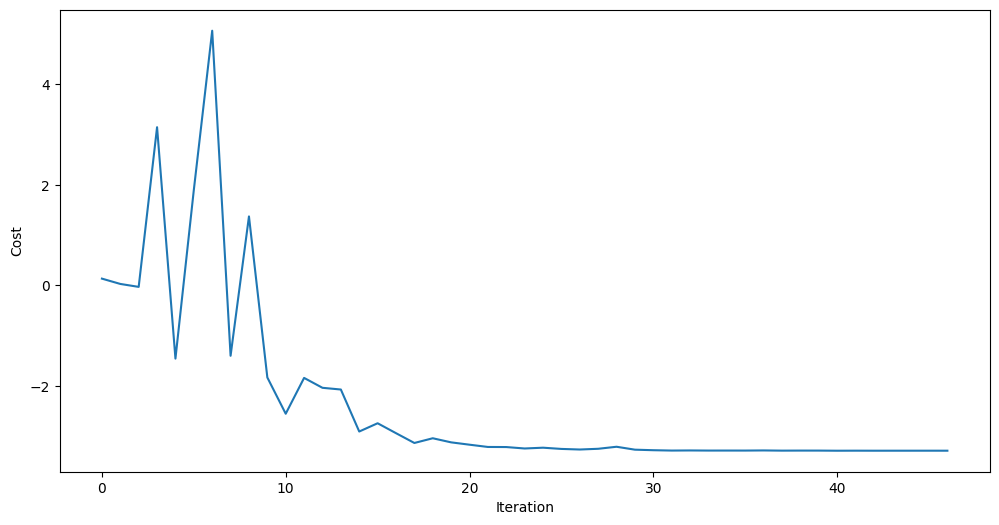

In [14]:
plt.figure(figsize=(12, 6))
plt.plot(objective_func_vals)
plt.xlabel("Iteration")
plt.ylabel("Cost")

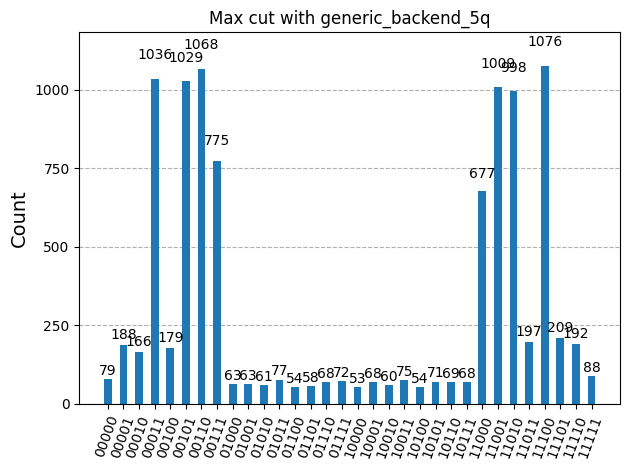

In [15]:
# Get the optimized parameters from the result
opt_params = result_qaoa.x
SHOTS = 10000


def sample_qaoa(opt_params, circuit, backend):

    # Submit the circuit to Sampler
    options = {"simulator": {"seed_simulator": seed}}
    sampler = Sampler(mode=backend, options=options)
    job = sampler.run([(circuit, opt_params)], shots=SHOTS)
    results_sampler = job.result()
    counts_list = results_sampler[0].data.meas.get_counts()
    display(plot_histogram(counts_list, title=f"Max cut with {backend.name}"))

    return counts_list


counts_list = sample_qaoa(opt_params, qaoa_circuit_transpiled, generic_backend)

In [16]:
eigenvalues, eigenvectors = np.linalg.eig(cost_hamiltonian)
ground_energy = min(eigenvalues).real
num_solutions = eigenvalues.tolist().count(ground_energy)
index_solutions = np.where(eigenvalues == ground_energy)[0].tolist()
print(f"The ground energy of the Hamiltonian is {ground_energy}")
print(f"The number of solutions of the problem is {num_solutions}")
print(f"The list of the solutions based on their index is {index_solutions}")

The ground energy of the Hamiltonian is -5.0
The number of solutions of the problem is 8
The list of the solutions based on their index is [3, 5, 6, 7, 24, 25, 26, 28]


In [17]:
def decimal_to_binary(decimal_list, n):
    return [bin(num)[2:].zfill(n) for num in decimal_list]


# Convert the solutions to quantum states
states_solutions = decimal_to_binary(index_solutions, n)
# Sort the dictionary items by their counts in descending order
sorted_states = sorted(counts_list.items(), key=lambda item: item[1], reverse=True)
# Take the top 'num_solutions' entries
top_states = sorted_states[:num_solutions]
# Extract only the states keys from the top entries
qaoa_ground_states = sorted([state for state, count in top_states])
print(f"The analytical solutions for the Max-cut problem are: {states_solutions}")
print(f"The QAOA ground states solutions for the Max-cut are: {qaoa_ground_states}")

The analytical solutions for the Max-cut problem are: ['00011', '00101', '00110', '00111', '11000', '11001', '11010', '11100']
The QAOA ground states solutions for the Max-cut are: ['00011', '00101', '00110', '00111', '11000', '11001', '11010', '11100']


In [18]:
real_backends = service.backends()
print(f"The quantum computers available for you are {real_backends}")

The quantum computers available for you are [<IBMBackend('ibm_brisbane')>, <IBMBackend('ibm_sherbrooke')>, <IBMBackend('ibm_torino')>]


In [19]:
noisy_fake_backends = []
for backend in real_backends:
    noisy_fake_backends.append(AerSimulator.from_backend(backend, seed_simulator=seed))
print(f"The noisy simulators are {noisy_fake_backends}")

The noisy simulators are [AerSimulator('aer_simulator_from(ibm_brisbane)'
             noise_model=<NoiseModel on ['ecr', 'reset', 'sx', 'measure', 'x', 'id']>), AerSimulator('aer_simulator_from(ibm_sherbrooke)'
             noise_model=<NoiseModel on ['ecr', 'reset', 'sx', 'measure', 'x', 'id']>), AerSimulator('aer_simulator_from(ibm_torino)'
             noise_model=<NoiseModel on ['reset', 'cz', 'sx', 'measure', 'x', 'id']>)]


In [ ]:
from qiskit import QuantumCircuit
from qiskit_ibm_runtime import QiskitRuntimeService

def accumulated_errors(backend: QiskitRuntimeService.backend, circuit: QuantumCircuit) -> list:
    """Compute accumulated gate and readout errors for a given circuit on a specific backend."""

    # Initializing quantities
    acc_single_qubit_error = 0
    acc_two_qubit_error = 0
    single_qubit_gate_count = 0
    two_qubit_gate_count = 0
    acc_readout_error = 0

    # Defining useful variables
    properties = backend.properties()
    config = backend.configuration()
    n = circuit.num_qubits
    qubit_layout = list(circuit.layout.initial_layout.get_physical_bits().keys())[:n]

    # READOUT ERROR

    for q in qubit_layout:
        readout_item = next(
        item for item in properties.readout_errors if item.qubits == [q]
    )
    p01 = readout_item.probabilities[0][1]  # measured 1, should be 0
    p10 = readout_item.probabilities[1][0]  # measured 0, should be 1
    acc_readout_error += p01 + p10

    #  Determine two-qubit gate used on this backend
    if "ecr" in config.basis_gates:
        two_qubit_gate = "ecr"
    elif "cz" in config.basis_gates:
        two_qubit_gate = "cz"
    else:
        two_qubit_gate = "cx"

    #  Loop over instructions
    for instruction in circuit.data:
        name = instruction.operation.name
        qubits = instruction.qubits

        if name in ["x", "rz", "sx"]:  # single-qubit gates
            single_qubit_gate_count += 1
            q_index = circuit.find_bit(qubits[0]).index
            gate_error = properties.gate_error(name, [q_index])
            acc_single_qubit_error += gate_error

        elif name == two_qubit_gate:
            two_qubit_gate_count += 1
            q0 = circuit.find_bit(qubits[0]).index
            q1 = circuit.find_bit(qubits[1]).index
            gate_error = properties.gate_error(name, [q0, q1])
            acc_two_qubit_error += gate_error

    # Total error
    acc_total_error = acc_two_qubit_error + acc_single_qubit_error + acc_readout_error

    return [
        acc_total_error,
        acc_two_qubit_error,
        acc_single_qubit_error,
        acc_readout_error,
        single_qubit_gate_count,
        two_qubit_gate_count,
    ]


In [ ]:
qaoa_transpiled_list = []
errors_and_counts_list = []
for noisy_fake_backend in noisy_fake_backends:
    pm = generate_preset_pass_manager(
        backend=noisy_fake_backend,
        optimization_level=3,
        seed_transpiler=seed,
    )
    circuit = pm.run(qaoa_circuit)
    qaoa_transpiled_list.append(circuit)

    errors_and_counts = accumulated_errors(noisy_fake_backend, circuit)
    errors_and_counts_list.append(errors_and_counts)
# You can print your results to visualize if they are correct
for backend, (
    acc_total_error,
    acc_two_qubit_error,
    acc_single_qubit_error,
    acc_readout_error,
    single_qubit_gate_count,
    two_qubit_gate_count,
) in zip(noisy_fake_backends, errors_and_counts_list):
    print(f"Backend {backend.name}")
    print(f"Accumulated two-qubit error of {two_qubit_gate_count} gates: {acc_two_qubit_error:.3f}")
    print(
        f"Accumulated one-qubit error of {single_qubit_gate_count} gates: {acc_single_qubit_error:.3f}"
    )
    print(f"Accumulated readout error: {acc_readout_error:.3f}")
    print(f"Accumulated total error: {acc_total_error:.3f}\n")

In [ ]:
plot_backend_errors_and_counts(noisy_fake_backends, errors_and_counts_list)

In [ ]:
# Submit your answer using the following code
grade_lab2_ex3(accumulated_errors)

In [22]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.visualization import circuit_drawer

# Step 1: Connect to IBM backend
service = QiskitRuntimeService()
backend = service.backend('ibmq_qasm_simulator')  # or 'ibm_brisbane' for real hardware

# Step 2: Set seed for reproducibility
seed = 42

# Step 3: Generate transpilation pass manager
pm = generate_preset_pass_manager(
    optimization_level=3,
    backend=backend,
    seed_transpiler=seed
)

# Step 4: Transpile your QAOA circuit (make sure qaoa_circuit is already defined from Exercise 2)
qaoa_circuit_transpiled = pm.run(qaoa_circuit)

# Step 5: Draw the transpiled circuit
qaoa_circuit_transpiled.draw("mpl", fold=False, idle_wires=False)


QiskitBackendNotFoundError: 'No backend matches the criteria. Learn more about available backends here https://quantum.cloud.ibm.com/docs/en/guides/qpu-information#view-your-resources'

In [23]:
from qiskit_ibm_runtime import QiskitRuntimeService

# Load your IBM Quantum account
service = QiskitRuntimeService()

# List available backends
for backend in service.backends():
    print(backend.name, "| Simulator:", backend.simulator, "| Status:", backend.status().status_msg)


ibm_brisbane | Simulator: False | Status: active
ibm_sherbrooke | Simulator: False | Status: active
ibm_torino | Simulator: False | Status: active
